# **Лабораторная работа 4**

## [Description](#description_)
## [Imports](#imports_)
## [Globals](#globals_)
## [Utils](#utils_)
## [Data_preparation](#data_prep_)
## [Dataset](#dataset_)
## [Model](#model_)
## [Training](#training_)
## [Results](#results_)


## Description <span id=description_></span>

*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

В данном задании вашей задачей будет построить простую модель для задачи **Image Captioning** - по изображению (image) сгенерировать текстовый заголовок (caption)

В ноутбуке будет несколько оцениваемых частей:
1. **Подготовка данных для модели** (*4 балла*) --> требуется заполнить пропуски и составить пайплайн предобработки данных
2. **Построение модели** (*3 балла*) --> требуется заполнить пропуски и составить пайплайн сборки модели
3. **Обучение модели** (*3 балла*) --> требуется заполнить пропуски и составить пайплайн обучения модели
4. **Оценка результатов** (*2 балл*) --> требуется заполнить пропуски и получить предсказания модели
5. **Валидация качества** (*3+ баллов*) --> вам нужно будет обучить модель, чтобы превзойти определённые пороги на валидационной выборке

**Структура данных:** 
- Вместе с заданием вам предложен файл __dataset.tar.gz__, в нём вы найдёте папку data, в которой присутствуют две папки с изображениями (**train** и **val**) в формате .png и два файла **captions_train.tsv** и **captions_val.tsv**
- В файлах captions находятся таблицы с 6 полями, разделёнными через **\t**, содержащими `img_id` (название файла с изображением в соответствующей папке) и `caption #1-#5` (5 текстовых заголовков для изображения __img_id__)
- **ВАЖНО!!!** Не используйте val в обучении модели, только в тестах, т.к. часть баллов в конце ноутбука будет выдаваться в зависимости от результатов вашей модели на val выборке и если вы будете учиться на val срезе, то **баллы за всю лабораторную будут аннулированы**

**Концепция простой модели**
- Будем рассматривать задачу предсказания следующего слова в предложении, имея изображение и предыдущие слова
- Для получения фичей из изображений будем использовать крупную свёрточную предобученную архитектуру
- Для получения фичей из предыдущего текста будем использовать рекуррентную архитектуру с предобученными эмбеддингами
- Сконкатенируем фичи по изображению и по тексту, чтобы получить финальный набор фичей
- Классификатор, завершающийся линейным слоем к размеру словаря над финальным набором фичей
- LogSoftmax + NLLLoss для оценки предсказания

**Модели большие, подсчёты не быстрые - закладывайте время на обучение моделей**

А так же в экспериментах обязательно подумайте можно ли как-то ускорить этот процесс?

------------------------------

***Полезный комментарий:***

*Местами, в коде вы будете встречать выполнение bash скриптов - их легко распознать по комментарию `#!g1.1:bash` вверху страницы.*

*Если вы пользуетесь датосферой, то оставьте как есть, всё сработает, а вот если Google colab или что-то ещё, то замните код скриптов так, чтобы он начинался с `!`.*

*К примеру:*

*Изначальный блок:*
```bash
#!g1.1:bash
ls -sh dataset.tar.gz
```

*Заменённый блок:*
```bash
!ls -sh dataset.tar.gz
```

------------------------------

***Полезный комментарий 2:*** Местами в коде вы будете встречать `assert`-ы, их задача - помочь и подсказать вам, но если вы (в рамках экспериментов или просто сами) меняете что-то концептуально, то эти `assert`-ы могут перестать вас правильно проверять. Снимать баллы за подобное не будем, если сделанная вами логика... *кхэм*... логична :)

## Imports <span id=imports_></span>

In [1]:
import collections
import enum
import functools
import os
import pickle
import textwrap
import requests
import random
import re
import urllib
import warnings
from typing import Literal, Optional


import cv2
import einops
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import termcolor
import torch
from torch import nn
import torchtext
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm


%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

## Globals <span id=globals_></span>

In [2]:
DATA_FOLDER = "./data/data"
SPLITS = ["train", "val"]
CHANNEL_MEAN_TRAIN_PICKLE = "CHANNEL_MEAN_TRAIN.pickle"
CHANNEL_STD_TRAIN_PICKLE = "CHANNEL_STD_TRAIN.pickle"
GLOVE_VOCAB_EMBEDDINGS_PICKLE = "glove.pickle"
DEVICE = "cuda:5"  # "cpu"
DEBUG = False  # True
BATCH_SIZE = 32


class Token(enum.Enum):
    UNK = "<UNK>"
    BOS = "<BOS>"
    EOS = "<EOS>"
    PAD = "<PAD>"

    @property
    def id(self):
        return self.token_to_id_dict()[self]

    @staticmethod
    def from_id(token_id):
        return list(Token)[token_id]

    @staticmethod
    @functools.cache
    def token_to_id_dict():
        return {v: i for i, v in enumerate(Token)}

<IPython.core.display.Javascript object>

## Utils <span id=utils_></span>

In [3]:
def name_from_fstring(string: str) -> str:
    return string.split("=")[0]


def load_pickle(pickle_filename: str):
    return pickle.load(open(pickle_filename, "rb"))


def get_yadisk_download_url(
    yadisk_url: str,
    base_url="https://cloud-api.yandex.net/v1/disk/public/resources/download?",
) -> str:
    final_url = base_url + urllib.parse.urlencode(dict(public_key=yadisk_url))
    response = requests.get(final_url)
    download_url = response.json()["href"]
    return download_url


def write_response_content(url: str, filename: str) -> None:
    download_response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(download_response.content)


def freeze_model(model: torch.nn.Module) -> None:
    for parameter in model.parameters():
        parameter.requires_grad = False


@torch.inference_mode()
def get_module_output_shape(module: torch.nn.Module, input_shape):
    return module(torch.empty(input_shape)).shape

<IPython.core.display.Javascript object>

## 0. Скачиваем и распаковываем данные

In [ ]:
write_response_content(
    url=get_yadisk_download_url(yadisk_url="https://disk.yandex.ru/d/b84AkmdsYEpWNg"),
    filename="dataset.tar.gz",
)

In [ ]:
!tar -xvf dataset.tar.gz -C .

## 1. Подготовка данных (***4 балла***) <span id=data_prep_></span>

In [4]:
@functools.cache
def read_caption_dataframe(split: SPLITS):
    return pd.read_csv(
        os.path.join(DATA_FOLDER, f"captions_{split}.tsv"), sep="\t"
    ).set_index("img_id")

<IPython.core.display.Javascript object>

In [5]:
def imread(split: SPLITS, img_id: str) -> np.array:
    return cv2.imread(os.path.join(DATA_FOLDER, split, img_id))


def plot_image_with_captions(split: SPLITS, img_id: str, caption_width=40):
    plt.imshow(imread(split=split, img_id=img_id))
    captions = read_caption_dataframe(split).loc[img_id]
    captions_shortened = "\n".join(
        textwrap.shorten(c, width=caption_width) for c in captions
    )
    plt.title(captions_shortened, loc="left")


def get_random_split_and_image_ids(n_images=1):
    split = random.choice(SPLITS)
    img_ids = read_caption_dataframe(split).sample(n_images).index.to_numpy()
    return split, img_ids


def plot_random_image_with_captions_grid(
    n_rows=2, n_cols=5, figsize=(20, 15), caption_width=40
):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    split, img_ids = get_random_split_and_image_ids(n_images=n_rows * n_cols)

    for ax, img_id in zip(fig.axes, img_ids):
        plt.sca(ax)
        plot_image_with_captions(
            split=split, img_id=img_id, caption_width=caption_width
        )

    fig.tight_layout()

<IPython.core.display.Javascript object>

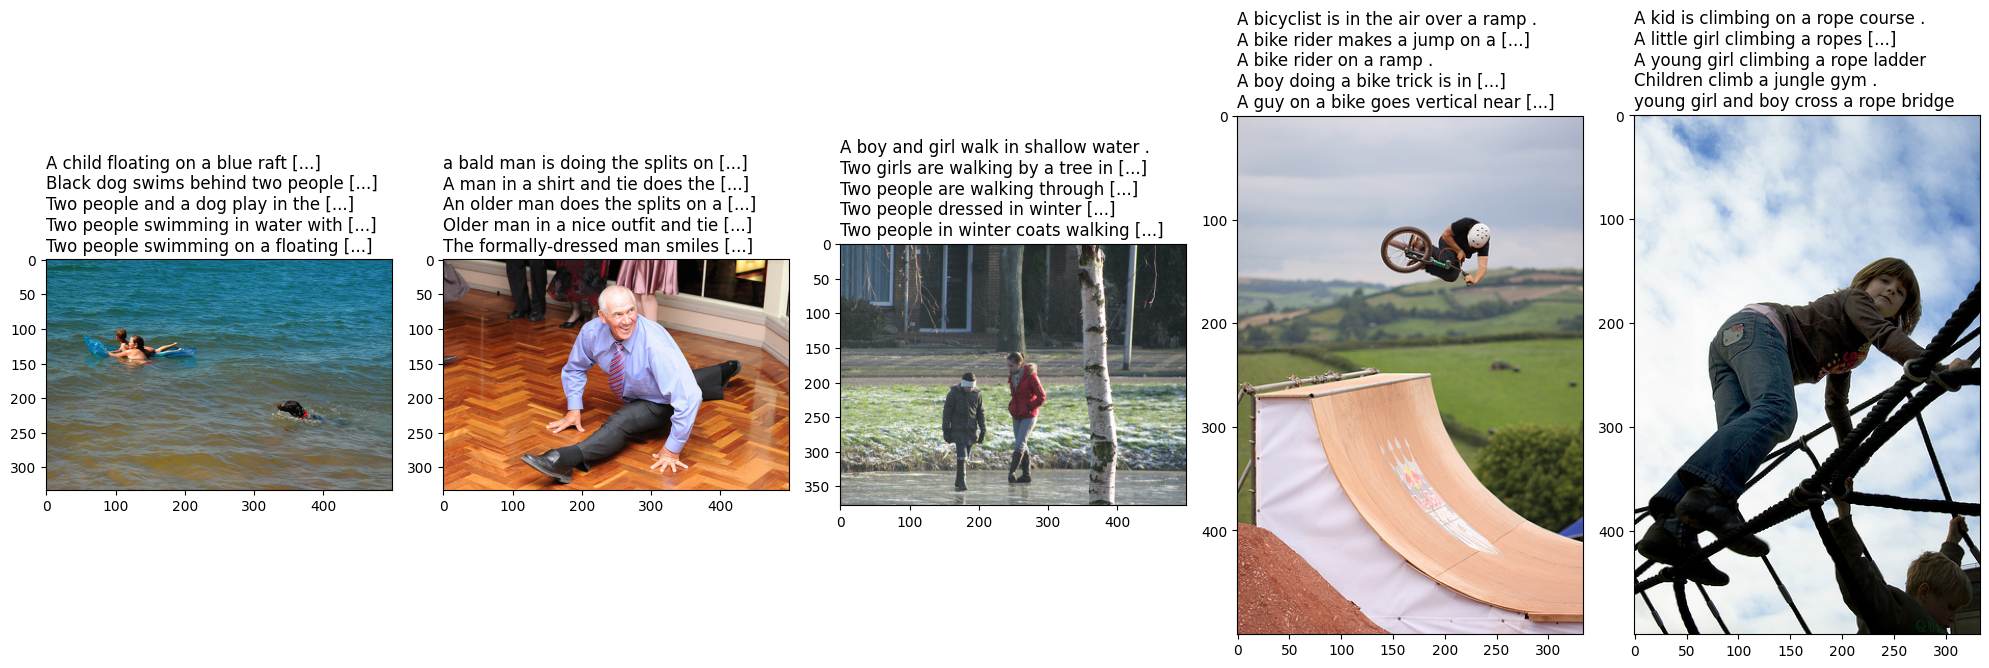

<IPython.core.display.Javascript object>

In [6]:
plot_random_image_with_captions_grid(n_rows=1, caption_width=40)

### 1.2 Предобработка изображений

**Сперва напишем предобработку для изображений**

In [7]:
def image_iterator_for_split(split: SPLITS):
    df = read_caption_dataframe(split)
    for img_id in df.index:
        yield imread(split, img_id)


def image_channelwise_sum(image: np.array):
    return einops.reduce(image.astype(int), "height width channel -> channel", "sum")


def calculate_channel_mean_and_std_for_split(split: SPLITS):
    n_pixels = 0
    channel_sum = None
    channel_squared_sum = None
    n_images = len(read_caption_dataframe(split))

    for image in tqdm(
        image_iterator_for_split(split),
        total=n_images,
        desc="Calculating channelwise stats",
    ):
        named_shape = einops.parse_shape(image, "height width channel")
        if channel_sum is None:
            channel_sum = np.zeros(named_shape["channel"])
            channel_squared_sum = np.zeros(named_shape["channel"])

        n_pixels += named_shape["height"] * named_shape["width"]
        channel_sum += image_channelwise_sum(image)
        channel_squared_sum += image_channelwise_sum(image.astype(int) ** 2)

    channel_mean = channel_sum / n_pixels
    channel_std = (channel_squared_sum / n_pixels - channel_mean**2) ** 0.5
    return channel_mean, channel_std


def save_train_channelwise_stats(channel_mean, channel_std):
    pickle.dump(channel_mean, open(CHANNEL_MEAN_TRAIN_PICKLE, "wb"))
    pickle.dump(channel_std, open(CHANNEL_STD_TRAIN_PICKLE, "wb"))

<IPython.core.display.Javascript object>

In [ ]:
save_train_channelwise_stats(*calculate_channel_mean_and_std_for_split("train"))

In [8]:
def build_image_preprocessing_transform(channel_mean=None, channel_std=None):
    if channel_mean is None:
        channel_mean = load_pickle(CHANNEL_MEAN_TRAIN_PICKLE)
    if channel_std is None:
        channel_std = load_pickle(CHANNEL_STD_TRAIN_PICKLE)
    return transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(channel_mean, channel_std)]
    )


def build_image_augmenting_transform(
    degrees=10,
    gaussian_blur_kernel_size=(5, 9),
    perspective_distortion_p=0.1,
    perspective_distortion_scale=0.15,
    elastic_transform_alpha=20.0,
    elastic_transform_sigma=5.0,
):
    return torch.nn.Sequential(
        transforms.RandomRotation(degrees=degrees),
        transforms.GaussianBlur(kernel_size=gaussian_blur_kernel_size),
        transforms.RandomPerspective(
            distortion_scale=perspective_distortion_scale,
            p=perspective_distortion_p,
        ),
        transforms.ElasticTransform(
            alpha=elastic_transform_alpha, sigma=elastic_transform_sigma
        ),
    )

<IPython.core.display.Javascript object>

In [9]:
def de_normalize(img: torch.Tensor):
    channel_mean = load_pickle(CHANNEL_MEAN_TRAIN_PICKLE)
    channel_std = load_pickle(CHANNEL_STD_TRAIN_PICKLE)
    return transforms.functional.to_pil_image(
        img * channel_std.reshape(3, 1, 1) + channel_mean.reshape(3, 1, 1)
    )


def showcase_image_transform(image_transform):
    split, [img_id] = get_random_split_and_image_ids()
    image = imread(split, img_id)

    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    for ax in fig.axes:
        plt.sca(ax)
        plt.imshow(de_normalize(image_transform(image)))

<IPython.core.display.Javascript object>

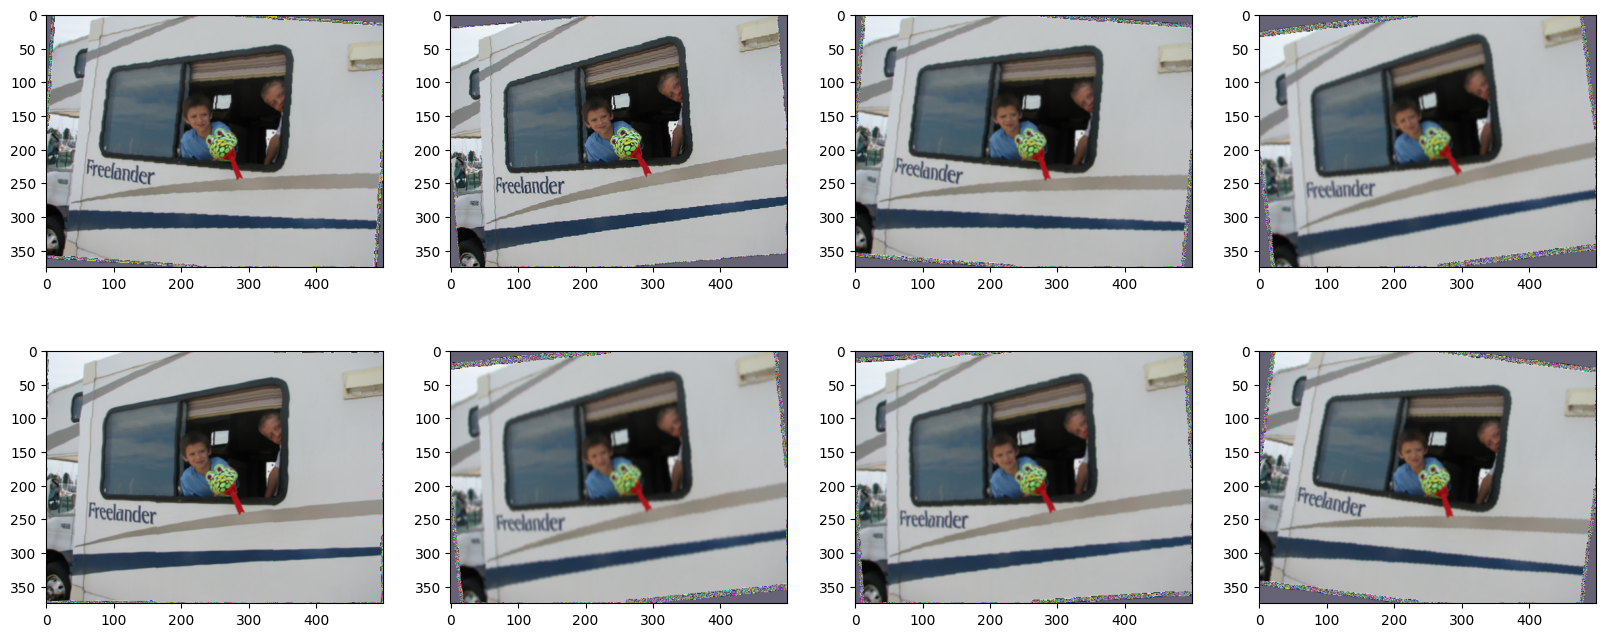

<IPython.core.display.Javascript object>

In [10]:
showcase_image_transform(
    transforms.Compose(
        [
            build_image_preprocessing_transform(),
            build_image_augmenting_transform(),
        ]
    )
)

### 1.3 Предобработка заголовков

**Затем напишем предобработку для заголовков**

Для простоты вычислений предлагаю сделать крайне простую токенизацию, пользуясь регулярными выражениями и библиотекой **re**

1. Приводим текст к нижнему регистру
2. Заменяем всю пунктуацию на пробелы
3. Убираем пробельные символы с концов строки
4. Разбиваем по ненулевой последовательности пробельных символов
5. Добавляем специальные токены \<BOS> (begin of sentence) и \<EOS> (end of sentence), чтобы обозначить границы заголовка для модели

In [11]:
def tokenize(text):
    text = re.sub(r"\W", " ", text)
    text = text.lower().strip()
    text = re.split(r"\s+", text)
    text = [Token.BOS.value] + text + [Token.EOS.value]
    return text

<IPython.core.display.Javascript object>

Соберём словарь из всех слов, что встречаются в заголовках в train
1. Токенизируем заголовки
2. Обновляем частоту всех отдельных токенов
3. Выкидываем все слова с частотой не больше минимума (допустим 3 - можете взять другое число) -> заменяем на специальный \<UNK> (unknown) токен
4. Записываем быстрое преобразование из токенов в индексы и наоборот

In [12]:
def count_tokens(split: SPLITS):
    token_counts = collections.Counter()
    caption_sizes_counts = collections.Counter()
    dataframe = read_caption_dataframe(split)

    for captions in dataframe.values:
        for caption in captions:
            tokens = tokenize(caption)
            token_counts.update(tokens)
            caption_sizes_counts.update([len(tokens)])

    return token_counts, caption_sizes_counts

<IPython.core.display.Javascript object>

In [13]:
def showcase_tokens(split: SPLITS):
    token_counts, caption_sizes_counts = count_tokens(split)
    max_seq_len = max(caption_sizes_counts)

    show_ = 20
    fig, ax = plt.subplots(3, 1, figsize=(20, 12))

    plt.subplot(312)
    token_counts = {
        k: v for k, v in sorted(token_counts.items(), key=lambda item: item[1])
    }
    plt.title("least popular words")
    plt.bar(list(token_counts.keys())[:show_], list(token_counts.values())[:show_])

    plt.subplot(311)
    token_counts = {
        k: v
        for k, v in sorted(token_counts.items(), key=lambda item: item[1], reverse=True)
    }
    plt.title("most popular words")
    plt.bar(list(token_counts.keys())[:show_], list(token_counts.values())[:show_])

    plt.subplot(313)
    plt.title("sequence sizes")
    plt.bar(list(caption_sizes_counts.keys()), list(caption_sizes_counts.values()))

    fig.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

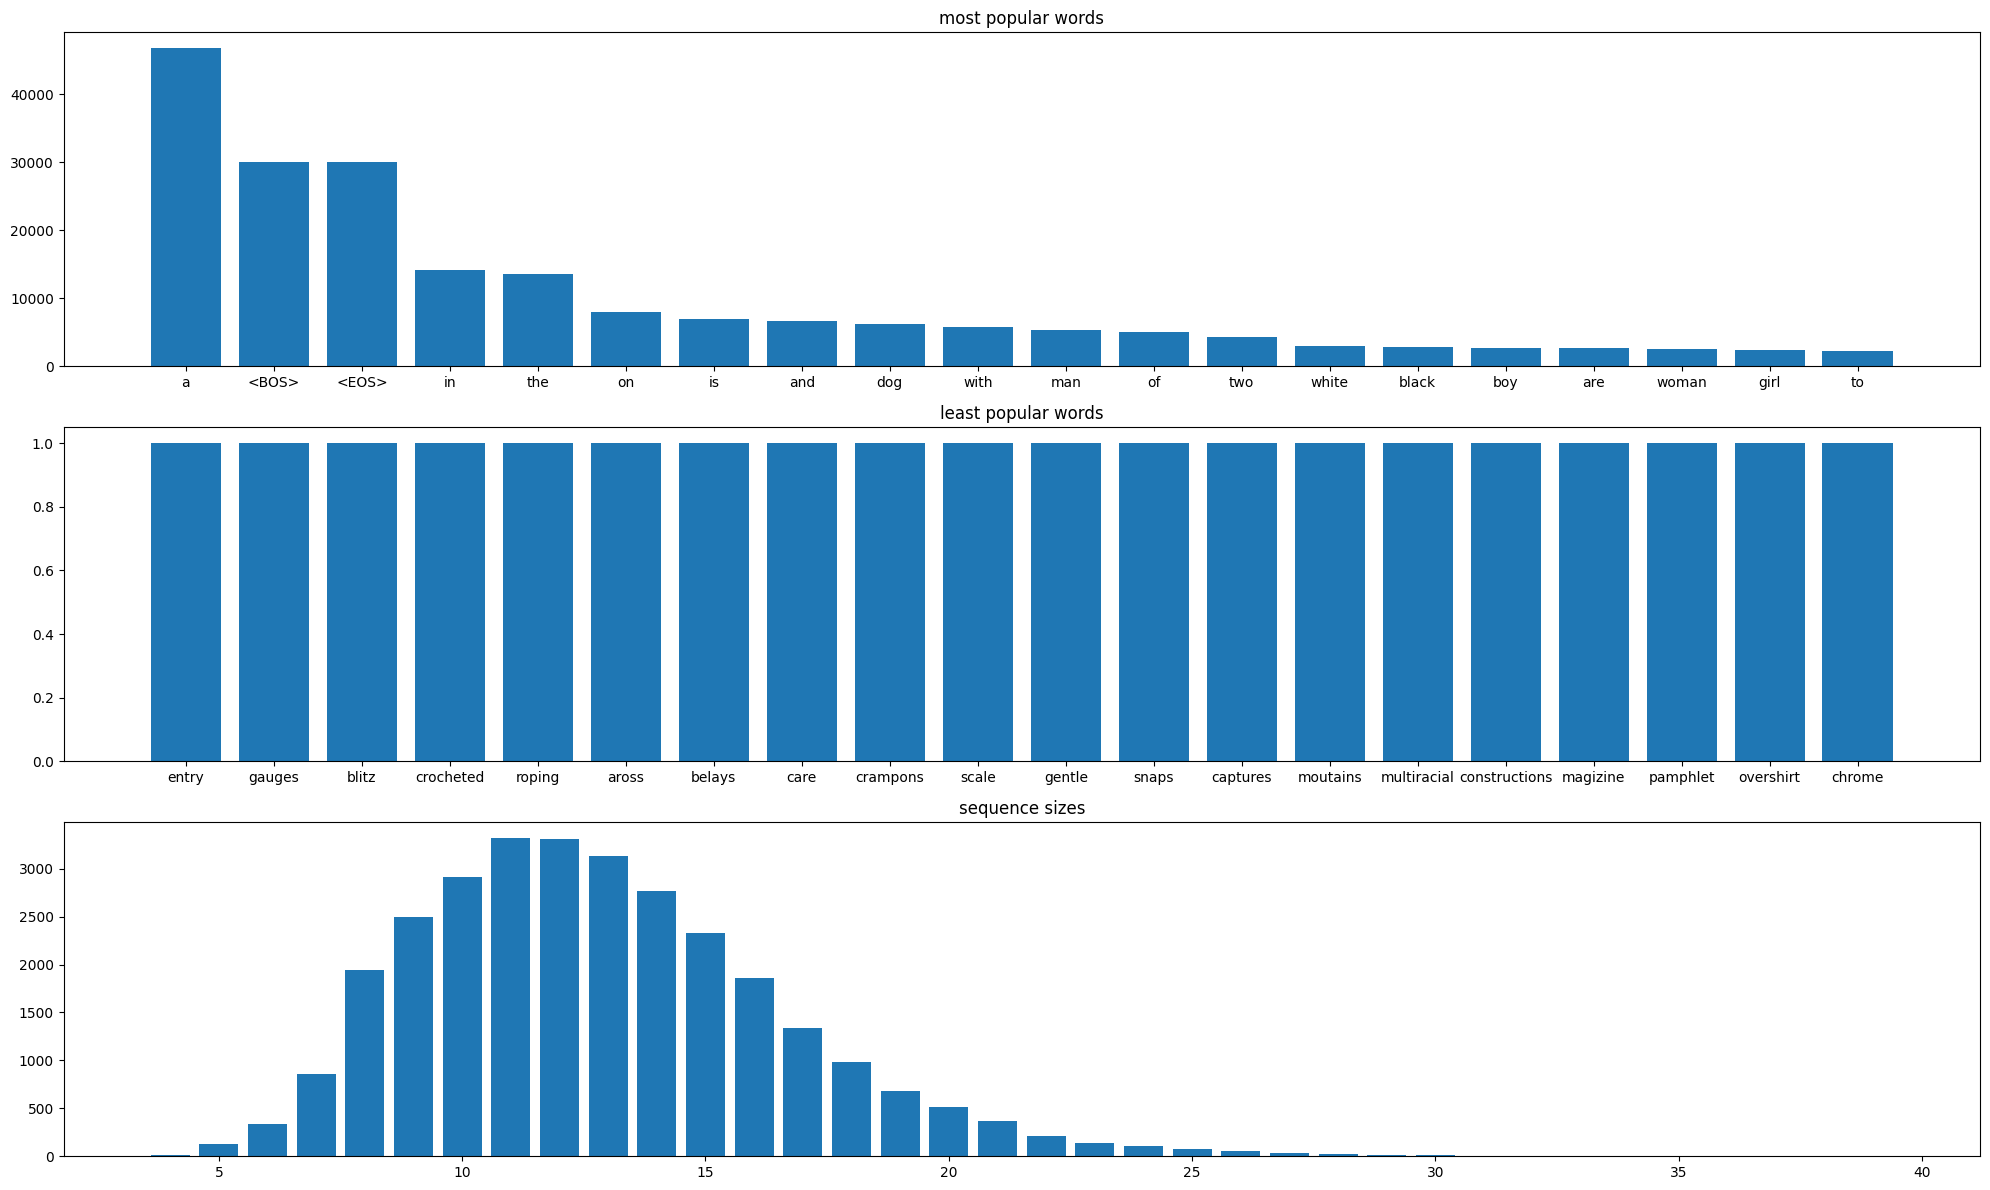

<IPython.core.display.Javascript object>

In [14]:
showcase_tokens("train")

In [15]:
def get_unique_tokens(token_counts: collections.Counter, min_count=3):
    token_counts = token_counts.copy()

    unique_tokens = [token.value for token in Token]
    for token in unique_tokens:
        if token in token_counts:
            token_counts.pop(token)

    for token, count in token_counts.most_common():
        if count >= min_count:
            unique_tokens.append(token)

    return unique_tokens

<IPython.core.display.Javascript object>

In [16]:
class Tokenizer:
    def __init__(self, split: SPLITS):
        self.token_counts, self.caption_sizes_counts = count_tokens(split)
        self.max_seq_len = max(self.caption_sizes_counts) + 2

        unique_tokens = get_unique_tokens(self.token_counts)
        token_to_id = {token: i for i, token in enumerate(unique_tokens)}
        self.token_to_id = collections.defaultdict(lambda: Token.UNK.id, token_to_id)
        self.id_to_token = {i: token for i, token in enumerate(unique_tokens)}

    def text_to_ids(self, text) -> list[int]:
        return [self.token_to_id[token] for token in tokenize(text)]

    def pad_to_max_length(self, tokens: list[int]):
        return tokens + [Token.PAD.id] * (self.max_seq_len - len(tokens))

    def to_text(self, token_ids) -> str:
        return " ".join([self.id_to_token[i] for i in token_ids])


@functools.cache
def get_tokenizer():
    return Tokenizer("train")


def get_max_number_of_tokens_in_sentence():
    return get_tokenizer().max_seq_len

<IPython.core.display.Javascript object>

In [17]:
def test_tokenizer():
    text = "Some random text I wrote. And the one, that cann't be forgotten unless I'll decide that... Tho it's still great"
    toks = tokenize(text)
    tokenizer = Tokenizer("train")
    ids = tokenizer.text_to_ids(text)
    print(toks)
    print(ids)
    assert toks[0] == "<BOS>" and toks[-1] == "<EOS>"
    assert (
        ids[0] == tokenizer.token_to_id["<BOS>"]
        and ids[-1] == tokenizer.token_to_id["<EOS>"]
    )


test_tokenizer()

['<BOS>', 'some', 'random', 'text', 'i', 'wrote', 'and', 'the', 'one', 'that', 'cann', 't', 'be', 'forgotten', 'unless', 'i', 'll', 'decide', 'that', 'tho', 'it', 's', 'still', 'great', '<EOS>']
[1, 104, 0, 0, 1372, 0, 9, 6, 60, 153, 0, 266, 498, 0, 0, 1372, 0, 0, 153, 0, 157, 158, 1540, 2469, 2]


<IPython.core.display.Javascript object>

### 1.4 Датасет <span id=dataset_></span>

**Сделаем класс датасета в стиле torch.utils.data.Dataset**

In [18]:
def generate_all_prefixes_and_next_token(text):
    tokenizer = get_tokenizer()
    token_ids = tokenizer.text_to_ids(text)
    prefixes = []
    next_tokens = []

    for end in range(1, len(token_ids)):
        prefix = token_ids[:end]
        prefix = tokenizer.pad_to_max_length(prefix)
        next_token = token_ids[end]

        prefixes.append(prefix)
        next_tokens.append(next_token)

    prefixes = torch.from_numpy(np.array(prefixes))
    next_tokens = torch.from_numpy(np.array(next_tokens))
    return prefixes, next_tokens


def generate_all_prefixes_and_next_token_for_all_image_captions(captions):
    captions_prefixes_and_next_tokens = [
        generate_all_prefixes_and_next_token(caption) for caption in captions
    ]
    captions_prefixes, captions_next_tokens = zip(*captions_prefixes_and_next_tokens)

    captions_prefixes, _ = einops.pack(captions_prefixes, "* max_length")
    captions_next_tokens, _ = einops.pack(captions_next_tokens, "*")

    return captions_prefixes, captions_next_tokens


class ImageCaptioningDataset(torch.utils.data.Dataset):
    """
    imgs_path ~ путь к папке с изображениями
    captions_path ~ путь к .tsv файлу с заголовками изображений
    """

    def __init__(self, split="train"):
        super(ImageCaptioningDataset).__init__()
        # Читаем и записываем из файлов в память класса, чтобы быстро обращаться внутри датасета
        # Если не хватает памяти на хранение всех изображений, то подгружайте прямо во время __getitem__, но это замедлит обучение
        # Проведите всю предобработку, которую можно провести без потери вариативности датасета, здесь

        self.split = split
        self.in_seq_and_out_words = self._preprocess_captions()
        self.images = self._preprocess_images()

    def _preprocess_captions(self):
        caption_dataframe = read_caption_dataframe(self.split)
        all_captions_and_next_tokens = []

        for i, captions in tqdm(
            enumerate(caption_dataframe.values),
            total=len(caption_dataframe),
            desc="Preprocessing captions",
        ):
            all_captions_and_next_tokens.append(
                generate_all_prefixes_and_next_token_for_all_image_captions(captions)
            )

        return all_captions_and_next_tokens

    def _preprocess_images(self):
        preprocessing_transform = build_image_preprocessing_transform()
        caption_dataframe = read_caption_dataframe(self.split)
        images = []

        for i, img_id in enumerate(
            tqdm(
                caption_dataframe.index,
                desc="Preprocessing images",
                total=len(caption_dataframe),
            )
        ):
            if DEBUG and i >= 100:
                break
            image = imread(self.split, img_id)
            image = preprocessing_transform(image)
            images.append(image)

        return images

    def __getitem__(self, index):
        # Получаем предобработанное изображение
        image = self.images[index]

        # Получаем по каждому заголовку набор in текстов - out слов
        #   в каждом заголовке берём всевозможные не пустые префиксы как in и следующее за префиксом слово как out
        #   применяем padding ко всем текстам в in
        in_seqs, out_words = self.in_seq_and_out_words[index]

        return image, in_seqs, out_words

    def __len__(self):
        return len(self.images)


@functools.cache
def get_dataset(split: SPLITS = "train"):
    return ImageCaptioningDataset(split)

<IPython.core.display.Javascript object>

In [19]:
def test_dataset():
    ds_train = get_dataset("train")
    ds_val = get_dataset("val")

    img_, in_seqs_, out_words_ = ds_train[0]

    assert isinstance(img_, torch.Tensor)
    assert isinstance(in_seqs_, torch.Tensor)
    assert isinstance(out_words_, torch.Tensor)

    assert img_.shape[0] == 3
    assert in_seqs_.shape[0] == out_words_.shape[0]
    assert get_tokenizer().id_to_token[out_words_[-1].item()] == "<EOS>"

    assert DEBUG or ds_train.__len__() == len(
        os.listdir(os.path.join(DATA_FOLDER, "train"))
    )
    assert DEBUG or ds_val.__len__() == len(
        os.listdir(os.path.join(DATA_FOLDER, "val"))
    )

    print(img_.shape)
    print(in_seqs_.shape)
    print(out_words_.shape)

    plt.imshow(de_normalize(img_))
    plt.show()

    # Только если вы возвращаете сразу группу, если вы возвращаете в __getitem__ один элемент, то просто игнорируйте этот блок
    k = 10

    # Для паддингов справа
    # Здесь должна быть лесенка, если вы не перемешиваете дополнительно зачем-то in_seqs в __getitem__
    print(in_seqs_[: k + 1, : k + 1].numpy())
    print("\n")
    # А тут вы должны узнать эти числа из матрицы выше
    print("    ", out_words_[:k].numpy())

<IPython.core.display.Javascript object>

Preprocessing captions:   0%|          | 0/6000 [00:00<?, ?it/s]

Preprocessing images:   0%|          | 0/6000 [00:00<?, ?it/s]

Preprocessing captions:   0%|          | 0/1000 [00:00<?, ?it/s]

Preprocessing images:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([3, 500, 375])
torch.Size([58, 41])
torch.Size([58])


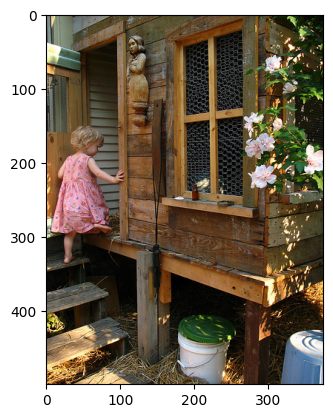

[[  1   3   3   3   3   3   3   3   3   3   3]
 [  1   4   3   3   3   3   3   3   3   3   3]
 [  1   4  44   3   3   3   3   3   3   3   3]
 [  1   4  44   5   3   3   3   3   3   3   3]
 [  1   4  44   5   4   3   3   3   3   3   3]
 [  1   4  44   5   4  89   3   3   3   3   3]
 [  1   4  44   5   4  89 173   3   3   3   3]
 [  1   4  44   5   4  89 173   8   3   3   3]
 [  1   4  44   5   4  89 173   8 118   3   3]
 [  1   4  44   5   4  89 173   8 118  54   3]
 [  1   4  44   5   4  89 173   8 118  54   4]]


     [  4  44   5   4  89 173   8 118  54   4]


<IPython.core.display.Javascript object>

In [20]:
test_dataset()

### 1.5 Даталоадер

In [43]:
# Сложим батч в следующем виде:
#   img_batch: [bs, c, h, w]
#   in_seqs_batch: [\sum_{i \in range(bs)}(\sum(seq_lens)_i), max_seq_len or local_max_seq_len]
#   out_words_batch: [\sum_{i \in range(bs)}(\sum(seq_lens)_i)]
#   text_to_image_align: [bs] --> число строк в in_seqs_batch и out_seqs_batch, соответствующих картинке


def collate_fn(batch):
    img_batch, in_seqs_batch, out_words_batch = zip(*batch)

    max_height = max([img.shape[1] for img in img_batch])
    max_width = max([img.shape[2] for img in img_batch])
    img_batch = [
        transforms.functional.center_crop(img, output_size=(max_height, max_width))
        for img in img_batch
    ]

    img_batch, _ = einops.pack(img_batch, "* c h w")
    in_seqs_batch, _ = einops.pack(in_seqs_batch, "* max_token_length")
    text_to_image_align = torch.from_numpy(np.array([len(i) for i in out_words_batch]))
    out_words_batch, _ = einops.pack(out_words_batch, "*")

    return (
        img_batch.to(DEVICE),
        in_seqs_batch.to(DEVICE),
        out_words_batch.to(DEVICE),
        text_to_image_align.to(DEVICE),
    )


def get_train_dataloader():
    return torch.utils.data.DataLoader(
        dataset=get_dataset("train"),
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn,
        shuffle=True,
        drop_last=True,
    )


def get_test_dataloader():
    return torch.utils.data.DataLoader(
        dataset=get_dataset("val"),
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn,
        shuffle=False,
        drop_last=False,
    )

<IPython.core.display.Javascript object>

In [44]:
def test_dataloader():
    batch_size = 32

    dataloader_train = get_train_dataloader()

    dataloader_val = get_test_dataloader()

    img_batch, in_seqs_batch, out_words_batch, text_to_image_align = next(
        iter(dataloader_train)
    )

    assert isinstance(img_batch, torch.Tensor)
    assert isinstance(in_seqs_batch, torch.Tensor)
    assert isinstance(out_words_batch, torch.Tensor)
    assert isinstance(text_to_image_align, torch.Tensor)

    assert img_batch.shape[:2] == torch.Size([batch_size, 3])
    assert in_seqs_batch.shape[0] == out_words_batch.shape[0]
    assert text_to_image_align.shape[0] == batch_size
    assert text_to_image_align.sum() == in_seqs_batch.shape[0]

    assert in_seqs_batch.dtype in {torch.int64, torch.LongTensor}
    assert out_words_batch.dtype in {torch.int64, torch.LongTensor}
    assert text_to_image_align.dtype in {torch.int64, torch.LongTensor}

    print(
        img_batch.shape,
        in_seqs_batch.shape,
        out_words_batch.shape,
        text_to_image_align.shape,
        sep="\n",
    )

<IPython.core.display.Javascript object>

In [45]:
test_dataloader()

torch.Size([32, 3, 500, 500])
torch.Size([1930, 41])
torch.Size([1930])
torch.Size([32])


<IPython.core.display.Javascript object>

## 2. Составляем модель (***3 балла***) <span id=model_></span>

[Модель](https://disk.yandex.ru/i/ZvTuLzSe4TGWmQ)

### 2.1 Фича-экстрактор для изображений

Возьмите какую-нибудь предобученную модель (к примеру resnet), по желанию заморозьте все или часть слоёв, наиболее вероятно уберите последний слой

In [46]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.img_fe = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights
        )
        self.out_dim = self.img_fe.fc.in_features
        self.img_fe.fc = nn.Identity()
        freeze_model(self.img_fe)

    def forward(self, imgs):
        return self.img_fe(imgs)


def get_image_feature_extractor():
    return ImageFeatureExtractor()


def get_image_feature_extractor_out_dim():
    return get_image_feature_extractor().out_dim

<IPython.core.display.Javascript object>

In [47]:
def test_image_feature_extractor():
    img_fe = get_image_feature_extractor()

    ds_train = get_dataset("train")
    img_, in_seqs_, out_words_ = ds_train[0]

    feat_img = img_fe(img_[None, :, :, :])

    assert len(feat_img.shape) == 2
    assert feat_img.shape[0] == 1

    print(f"outputs {feat_img.shape[1]} features from feature extractor")

<IPython.core.display.Javascript object>

In [48]:
test_image_feature_extractor()

/home/dkkoshman/YSDA/python3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


outputs 512 features from feature extractor


<IPython.core.display.Javascript object>

### 2.2 Фича-экстрактор для текста

Давайте скачаем предобученные glove вектора и инициализируем nn.Embedding ими, там где мы их знаем

In [ ]:
!wget -O glove.zip https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip

In [ ]:
!unzip glove.zip

In [ ]:
!ls -sh glove.*

In [30]:
def load_glove_weights(file_path, vocab, pad_token="<PAD>"):
    np.random.seed(19)
    print("Loading Glove Weights")
    # Инициализируем веса для всех слов стандартным нормальным распределением
    glove_weights = np.random.uniform(0, 1, (len(vocab), 300))
    mask_found = np.zeros(len(vocab), dtype=bool)

    with open(file_path, "r") as f:
        for line in tqdm(f, total=2196018):
            line = line.split()
            token = " ".join(line[:-300])
            embed = line[-300:]

            if token in vocab:
                ind = vocab[token]
                mask_found[ind] = True
                glove_weights[ind, :] = np.array(list(map(float, embed)), dtype=float)

    print(f"{mask_found.sum()} words from vocab of size {len(vocab)} loaded!")

    glove_weights[vocab[pad_token]] = np.zeros(300, dtype=float)
    return glove_weights, mask_found


def save_glove_vocab_embeddings_pickle(file_path):
    tokenizer = Tokenizer("train")
    glove_weights, mask_found = load_glove_weights(
        file_path, tokenizer.token_to_id, Token.PAD.name
    )
    pickle.dump(glove_weights, open(GLOVE_VOCAB_EMBEDDINGS_PICKLE, "wb"))

<IPython.core.display.Javascript object>

In [134]:
save_glove_vocab_embeddings_pickle("./glove.840B.300d.txt")

Counting tokens:   0%|          | 0/6000 [00:00<?, ?it/s]

Loading Glove Weights


  0%|          | 0/2196018 [00:00<?, ?it/s]

3470 words from vocab of size 3478 loaded!


<IPython.core.display.Javascript object>

In [31]:
class TextFeatureExtractor(nn.Module):
    def __init__(self, per_token_dim=16):
        super().__init__()

        glove_weights = load_pickle(GLOVE_VOCAB_EMBEDDINGS_PICKLE)
        glove_weights = torch.from_numpy(glove_weights).to(torch.float32)
        self.vocab_size, embedding_dimension = glove_weights.shape
        self.per_token_dim = per_token_dim
        self.embed = nn.Embedding(self.vocab_size, embedding_dimension)
        self.embed.weight = nn.Parameter(data=glove_weights, requires_grad=False)
        self.linear = nn.Linear(embedding_dimension, per_token_dim)

    def forward(self, in_seqs):
        embedding = self.embed(in_seqs)
        embedding = self.linear(embedding)
        embedding = einops.rearrange(
            embedding, "caption word weight -> caption (word weight)"
        )
        return embedding


def get_text_feature_extractor():
    return TextFeatureExtractor()


def get_text_feature_extractor_out_dim():
    return (
        get_max_number_of_tokens_in_sentence()
        * get_text_feature_extractor().per_token_dim
    )

<IPython.core.display.Javascript object>

In [32]:
def test_text_feature_extractor():
    ds_train = get_dataset("train")
    img_, in_seqs_, out_words_ = ds_train[0]

    text_fe = get_text_feature_extractor()
    feat_text = text_fe(in_seqs_)

    assert in_seqs_.shape[0] == feat_text.shape[0]
    assert (
        len(feat_text.shape) == 2
    ), "По каждому тексту вам нужен один вектор, а RNN блок возвращает output для каждого шага seq_len, не забудьте как-то это исправить"

    print(in_seqs_.shape)
    print(feat_text.shape)

<IPython.core.display.Javascript object>

In [33]:
test_text_feature_extractor()

torch.Size([58, 41])
torch.Size([58, 656])


<IPython.core.display.Javascript object>

### 2.3 Финальная модель

Сконкатенируйте полученные фичи и подайте в линейный слой (лучше сделать хотя 2 линейных слоя для большей гибкости).

Так же подумайте какие ещё блоки / слои тут могут быть нужны.

In [34]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, dropout_p=0.3, hid_size=512):
        super().__init__()

        self.img_fe = get_image_feature_extractor()
        self.text_fe = get_text_feature_extractor()

        img_fe_out_dim = get_image_feature_extractor_out_dim()
        text_fe_out_dim = get_text_feature_extractor_out_dim()

        self.fc = nn.Sequential(
            collections.OrderedDict(
                [
                    ("in2hid", nn.Linear(img_fe_out_dim + text_fe_out_dim, hid_size)),
                    ("act", nn.ReLU()),
                    ("drop", nn.Dropout(dropout_p)),
                    ("bnorm", nn.BatchNorm1d(hid_size)),
                    ("hid2out", nn.Linear(hid_size, self.text_fe.vocab_size)),
                    ("log_soft", nn.LogSoftmax(dim=-1)),
                ]
            )
        )

    def forward(self, img_batch, in_seqs_batch, text_to_image_align):
        img_batch = self.img_fe(img_batch)
        img_batch = torch.repeat_interleave(
            img_batch, repeats=text_to_image_align, dim=0
        )
        in_seqs_batch = self.text_fe(in_seqs_batch)
        x, _ = einops.pack([img_batch, in_seqs_batch], "batch *")
        token_log_probs = self.fc(x)
        return token_log_probs


def get_image_captioning_model():
    return ImageCaptioningModel()

<IPython.core.display.Javascript object>

In [38]:
def test_image_captioning_model():
    model = get_image_captioning_model().float().to(DEVICE)

    dataloader_train = get_train_dataloader()
    dataloader_val = get_test_dataloader()

    for dataloader in [dataloader_train, dataloader_val]:
        img_batch, in_seqs_batch, out_words_batch, text_to_image_align = next(
            iter(dataloader)
        )
        res = model(img_batch, in_seqs_batch, text_to_image_align)

    assert res.shape[0] == np.sum(out_words_batch.shape[0])
    assert res.shape[1] == get_text_feature_extractor().vocab_size

    print(res.shape)

<IPython.core.display.Javascript object>

In [49]:
test_image_captioning_model()

torch.Size([2044, 3478])


<IPython.core.display.Javascript object>

In [50]:
def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0) : j + 3] for j in range(len(i) - 3, -3, -3)]))


# Считаем общее число параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                termcolor.colored(
                    "{: <42} ~  {: <9} params ~ grad: {}".format(
                        param[0],
                        beautiful_int(num_params),
                        param[1].requires_grad,
                    ),
                    {True: "green", False: "red"}[param[1].requires_grad],
                )
            )
        sum_params += num_params
        if param[1].requires_grad:
            sum_learnable_params += num_params
    print(
        f"\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params"
    )
    return sum_params, sum_learnable_params


model_num_params(get_image_captioning_model())

img_fe.img_fe.conv1.weight                 ~  9.408     params ~ grad: False
img_fe.img_fe.bn1.weight                   ~  64        params ~ grad: False
img_fe.img_fe.bn1.bias                     ~  64        params ~ grad: False
img_fe.img_fe.layer1.0.conv1.weight        ~  36.864    params ~ grad: False
img_fe.img_fe.layer1.0.bn1.weight          ~  64        params ~ grad: False
img_fe.img_fe.layer1.0.bn1.bias            ~  64        params ~ grad: False
img_fe.img_fe.layer1.0.conv2.weight        ~  36.864    params ~ grad: False
img_fe.img_fe.layer1.0.bn2.weight          ~  64        params ~ grad: False
img_fe.img_fe.layer1.0.bn2.bias            ~  64        params ~ grad: False
img_fe.img_fe.layer1.1.conv1.weight        ~  36.864    params ~ grad: False
img_fe.img_fe.layer1.1.bn1.weight          ~  64        params ~ grad: False
img_fe.img_fe.layer1.1.bn1.bias            ~  64        params ~ grad: False
img_fe.img_fe.layer1.1.conv2.weight        ~  36.864    params ~ grad: False

(14608494, 2388582)

<IPython.core.display.Javascript object>

## 3. Пайплайн обучения (***3 балла***) <span id=training_></span>

### 3.1 Оптимайзер

In [51]:
def create_model_and_optimizer(lr=1e-3):
    model = get_image_captioning_model()
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, optimizer


# Убедитесь что всё сработало и создалось нормально и без ошибок
create_model_and_optimizer()

(ImageCaptioningModel(
   (img_fe): ImageFeatureExtractor(
     (img_fe): ResNet(
       (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (layer1): Sequential(
         (0): BasicBlock(
           (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu): ReLU(inplace=True)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         )
         (1): BasicBlock(
           (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

<IPython.core.display.Javascript object>

### 3.2 Один шаг обучения/валидации

In [52]:
def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for img_batch, in_seqs_batch, out_words_batch, text_to_image_align in tqdm(loader):
        optimizer.zero_grad()

        pred = model(img_batch, in_seqs_batch, text_to_image_align)
        loss = criterion(pred, out_words_batch)

        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())

    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names is not None:
        metrics = collections.defaultdict(list)
    with torch.no_grad():
        for img_batch, in_seqs_batch, out_words_batch, text_to_image_align in tqdm(
            loader
        ):
            pred = model(img_batch, in_seqs_batch, text_to_image_align)
            loss = criterion(pred, out_words_batch)

            losses_val.append(loss.item())

            # Можете добавить сюда любые метрики, которые хочется (см. код здесь и 3.3 за подробностями)
            if metric_names is not None:
                if "accuracy" in metric_names:
                    preds = torch.argsort(pred, dim=1, descending=True)
                    for k in metric_names["accuracy"]["top"]:
                        metrics[f"accuracy ~ top#{k}"].append(
                            np.mean(
                                [
                                    out_words_batch[i].item() in preds[i, :k]
                                    for i in range(out_words_batch.shape[0])
                                ]
                            )
                        )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])

    return np.mean(losses_val), metrics if metric_names else None

<IPython.core.display.Javascript object>

### 3.3 Цикл обучения

In [53]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
    save_only_best=True,
):
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f"model#{num_starts}"

    if os.path.exists(os.path.join(chkp_folder, model_name)):
        model_name = model_name + "_v2"
        warnings.warn(
            f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}"
        )
    os.makedirs(os.path.join(chkp_folder, model_name))

    losses = {"train": [], "val": []}
    lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = collections.defaultdict(list)

    for epoch in range(1, epochs + 1):
        print(f"#{epoch}/{epochs}:")

        lrs.append(get_lr(optimizer))

        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses["train"].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(
                model, val_loader, criterion, metric_names=metric_names
            )
            losses["val"].append(loss)
            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)

            # Сохраняем лучшую по валидации модель
            if (not save_only_best) or (loss < best_val_loss):
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "scheduler_state_dict": scheduler.state_dict(),
                        "losses": losses,
                    },
                    os.path.join("./chkp", model_name, f"{model_name}#{epoch}.pt"),
                )
                best_val_loss = loss

            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            display.clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot id", 1)]
                    for key, metric_meta in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(el[1] <= ww_metrics for el in plot_ids_)

                plot_ids = collections.defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append(el[0])

            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(20, 10))
            fig.suptitle(f"#{epoch}/{epochs}:")

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses["train"], "r.-", label="train")
            if separate_show:
                plt.title("loss on train")
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title("loss on validation")
                plt.grid()
            else:
                plt.title("losses")
            plt.plot(losses["val"], "g.-", label="val")
            plt.legend()

            plt.subplot(1, ww + ww_metrics, ww)
            plt.title("learning rate")
            plt.plot(lrs, "g.-", label="lr")
            plt.legend()
            plt.grid()

            if metric_names is not None:
                for plot_id, keys in plot_ids.items():
                    for key in keys:
                        plt.subplot(1, ww + ww_metrics, ww + plot_id)
                        plt.title(f"additional metrics #{plot_id}")
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], ".-", label=name)
                        plt.legend()
                        plt.grid()

            plt.show()

        if min_lr and get_lr(optimizer) <= min_lr:
            print(f"Learning process ended with early stop after epoch {epoch}")
            break

    return model, optimizer, losses

<IPython.core.display.Javascript object>

### 3.4 Обучаем модель

In [54]:
def train_model():
    dataloader_train = get_train_dataloader()

    dataloader_val = get_test_dataloader()

    model, optimizer = create_model_and_optimizer()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.25, patience=4, threshold=0.001, verbose=True
    )

    criterion = nn.NLLLoss()

    model, optimizer, losses = learning_loop(
        model=model,
        optimizer=optimizer,
        train_loader=dataloader_train,
        val_loader=dataloader_val,
        criterion=criterion,
        scheduler=scheduler,
        epochs=10 if DEBUG else 100,
        min_lr=1e-6,
        val_every=1,
        draw_every=1,
        separate_show=False,
        metric_names={
            "accuracy": {"top": [1, 5], "plot_id": 1},
        },
        chkp_folder="./chkp",
    )

    return model

<IPython.core.display.Javascript object>

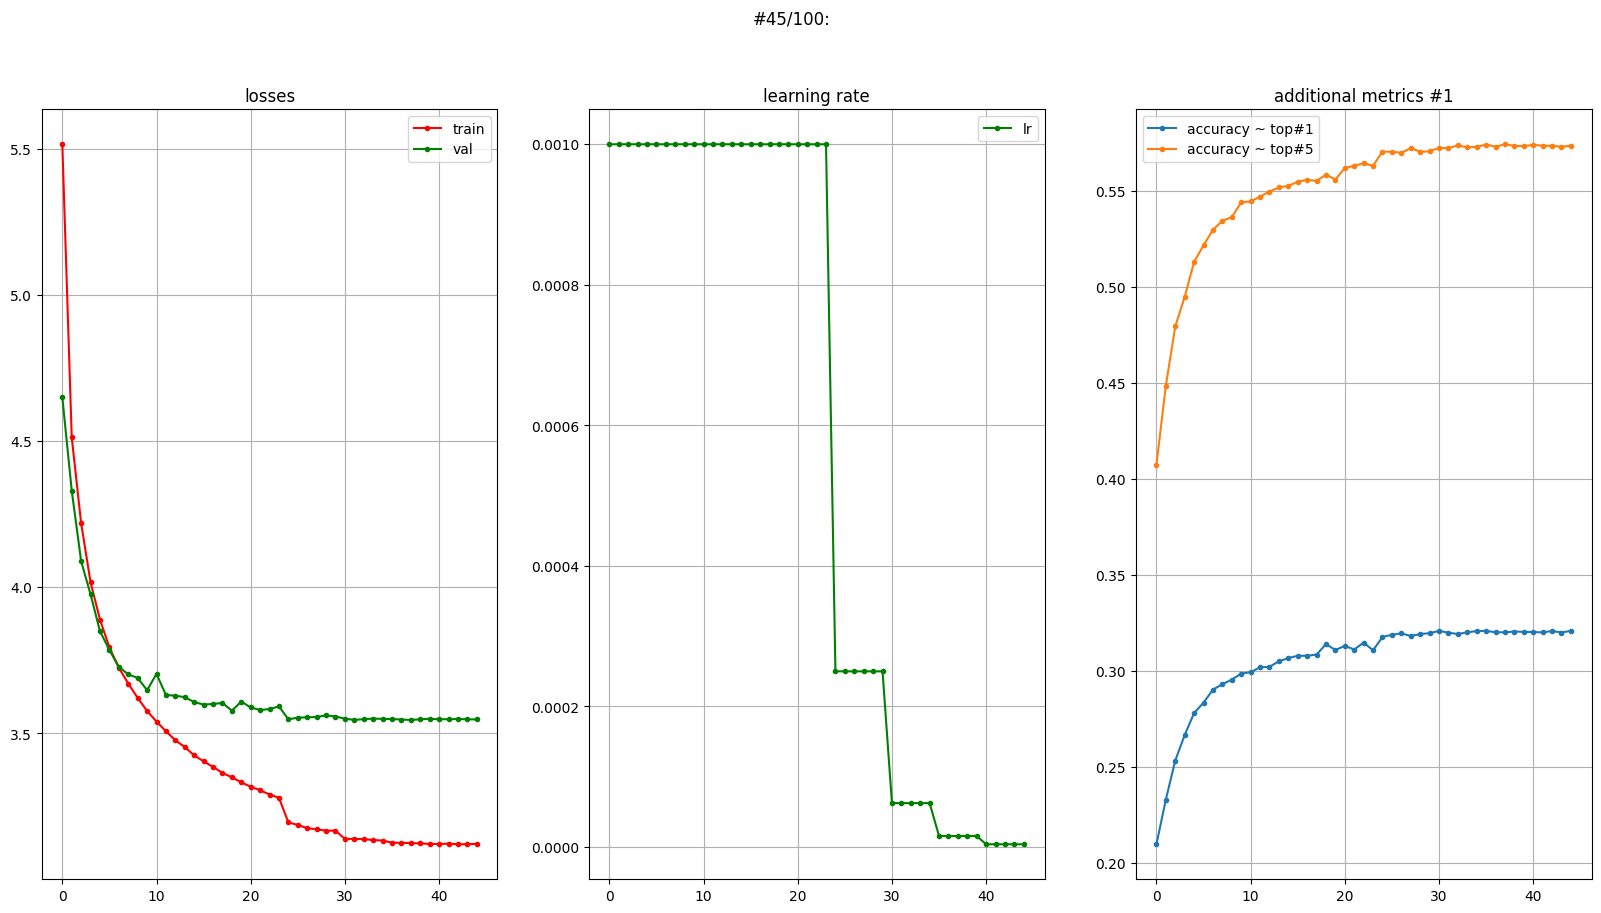

Learning process ended with early stop after epoch 45


<IPython.core.display.Javascript object>

In [55]:
train_model()

### 3.5 Загрузка чекпоинта

#### **Не запускайте этот блок, если не понимаете для чего это в данную секунду!**

#### **Так можно случайно перезатереть несколько часов вычислений, если не скопировать их в отдельную переменную/чекпоинт**

In [60]:
def load_model(epoch, model_name, chkp_folder="./chkp"):
    model = get_image_captioning_model()
    checkpoint = torch.load(
        os.path.join(chkp_folder, model_name, f"{model_name}#{epoch}.pt")
    )
    model.load_state_dict(checkpoint["model_state_dict"])
    return model

<IPython.core.display.Javascript object>

In [122]:
def resume_train():
    assert (
        False
    ), "Are you sure? If not - stop right here, otherwise - comment this assert line"

    chkp_folder = ...
    model_name = ...
    epoch = ...
    checkpoint = torch.load(
        os.path.join(chkp_folder, model_name, f"{model_name}#{epoch}.pt")
    )

    # Создаём те же классы, что и внутри чекпоинта
    model, optimizer = create_model_and_optimizer(...)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.25, patience=4, threshold=0.001, verbose=True
    )

    # Загружаем состояния из чекпоинта
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    epoch = checkpoint["epoch"]
    losses = checkpoint["losses"]

<IPython.core.display.Javascript object>

## 4. Оценка результатов (***2 балл***) <span id=results_></span>

### 4.1 Генерация

In [77]:
def build_batch(image, in_seqs_batch):
    img_batch = einops.repeat(image, "c h w -> () c h w")
    text_to_image_align = torch.tensor([len(in_seqs_batch)])
    return img_batch, in_seqs_batch, text_to_image_align


def get_initial_token_sequence_batch(n_candidates):
    tokens = torch.full(
        [n_candidates, get_max_number_of_tokens_in_sentence()], Token.PAD.id, dtype=int
    )
    tokens[:, 0] = Token.BOS.id
    return tokens


@torch.inference_mode()
def greedy_generate(model, image) -> str:
    model.eval()
    if not torch.is_tensor(image):
        image = transforms.functional.to_tensor(image)

    tokens = get_initial_token_sequence_batch(1)

    for i in range(1, get_max_number_of_tokens_in_sentence()):
        pred = model(*build_batch(image, tokens))
        tokens[0][i] = pred.argmax(1)
        if tokens[0][i] == Token.EOS.id:
            break

    caption = get_tokenizer().to_text(tokens.numpy().squeeze())
    return caption


def update_candidates(
    candidates,
    candidates_log_prob,
    next_token_log_prob,
    token_position,
    out_n_candidates,
):
    n_candidates = candidates.shape[0]
    vocab_size = next_token_log_prob.shape[1]

    candidates = einops.repeat(
        candidates, f"candidate token -> (candidate {vocab_size}) token"
    ).clone()
    candidates_log_prob = einops.repeat(
        candidates_log_prob, f"prob -> (prob {vocab_size})"
    )
    next_token_log_prob = einops.rearrange(
        next_token_log_prob, "candidate token -> (candidate token)"
    )
    token_ids = torch.arange(vocab_size).repeat(n_candidates)

    candidates[:, token_position] = token_ids
    candidates_log_prob += next_token_log_prob
    candidates_ids = torch.multinomial(
        nn.functional.softmax(candidates_log_prob, dim=0), num_samples=out_n_candidates
    )

    candidates = candidates[candidates_ids]
    candidates_log_prob = candidates_log_prob[candidates_ids]

    return candidates, candidates_log_prob


def pack_finished_candidates(
    finished_candidates_sequence, finished_candidates_log_prob_sequence
):
    finished_candidates, _ = einops.pack(
        [i for i in finished_candidates_sequence if i.numel()], "* max_seq_len"
    )
    finished_candidates_log_prob, _ = einops.pack(
        [i for i in finished_candidates_log_prob_sequence if i.numel()], "*"
    )
    return finished_candidates, finished_candidates_log_prob


@torch.inference_mode()
def generate(model, image, n_candidates=BATCH_SIZE) -> str:
    model.eval()
    if not torch.is_tensor(image):
        image = transforms.functional.to_tensor(image)

    candidates = get_initial_token_sequence_batch(n_candidates)
    candidates_log_prob = torch.zeros(n_candidates)

    finished_candidates = torch.tensor([])
    finished_candidates_log_prob = torch.tensor([])

    for i in range(1, get_max_number_of_tokens_in_sentence()):
        pred = model(*build_batch(image, candidates))
        assert not pred.requires_grad
        candidates, candidates_log_prob = update_candidates(
            candidates, candidates_log_prob, pred, i, n_candidates
        )

        candidates_eos_index = candidates[:, i] == Token.EOS.id

        if candidates_eos_index.sum():
            (
                finished_candidates,
                finished_candidates_log_prob,
            ) = pack_finished_candidates(
                [finished_candidates, candidates[candidates_eos_index]],
                [
                    finished_candidates_log_prob,
                    candidates_log_prob[candidates_eos_index],
                ],
            )
            candidates = candidates[~candidates_eos_index]
            candidates_log_prob = candidates_log_prob[~candidates_eos_index]

    finished_candidates, finished_candidates_log_prob = pack_finished_candidates(
        [finished_candidates, candidates],
        [finished_candidates_log_prob, candidates_log_prob],
    )

    final_candidate_id = torch.multinomial(
        nn.functional.softmax(finished_candidates_log_prob, dim=0),
        num_samples=1,
    ).item()
    final_candidate = finished_candidates[final_candidate_id]

    caption = get_tokenizer().to_text(final_candidate.numpy())
    return caption


def strip_special_tokens(text):
    for token in Token:
        text = text.replace(token.value, "")
    text = re.sub(r"\s+", " ", text)
    text = text.strip().capitalize() + " ."
    return text

<IPython.core.display.Javascript object>

### 4.2 Посмотрим на предсказания модели

In [109]:
def showcase_predictions(model, row=1, col=5, figsize=(20, 15)):
    fig, axes = plt.subplots(row, col, figsize=figsize)
    for ax in fig.axes:
        plt.sca(ax)
        split, [img_id] = get_random_split_and_image_ids()
        img = imread(split, img_id)

        pred_caption = strip_special_tokens(generate(model, img))
        plt.title(pred_caption, y=-0.5)

        plot_image_with_captions(split, img_id)

    fig.tight_layout()

<IPython.core.display.Javascript object>

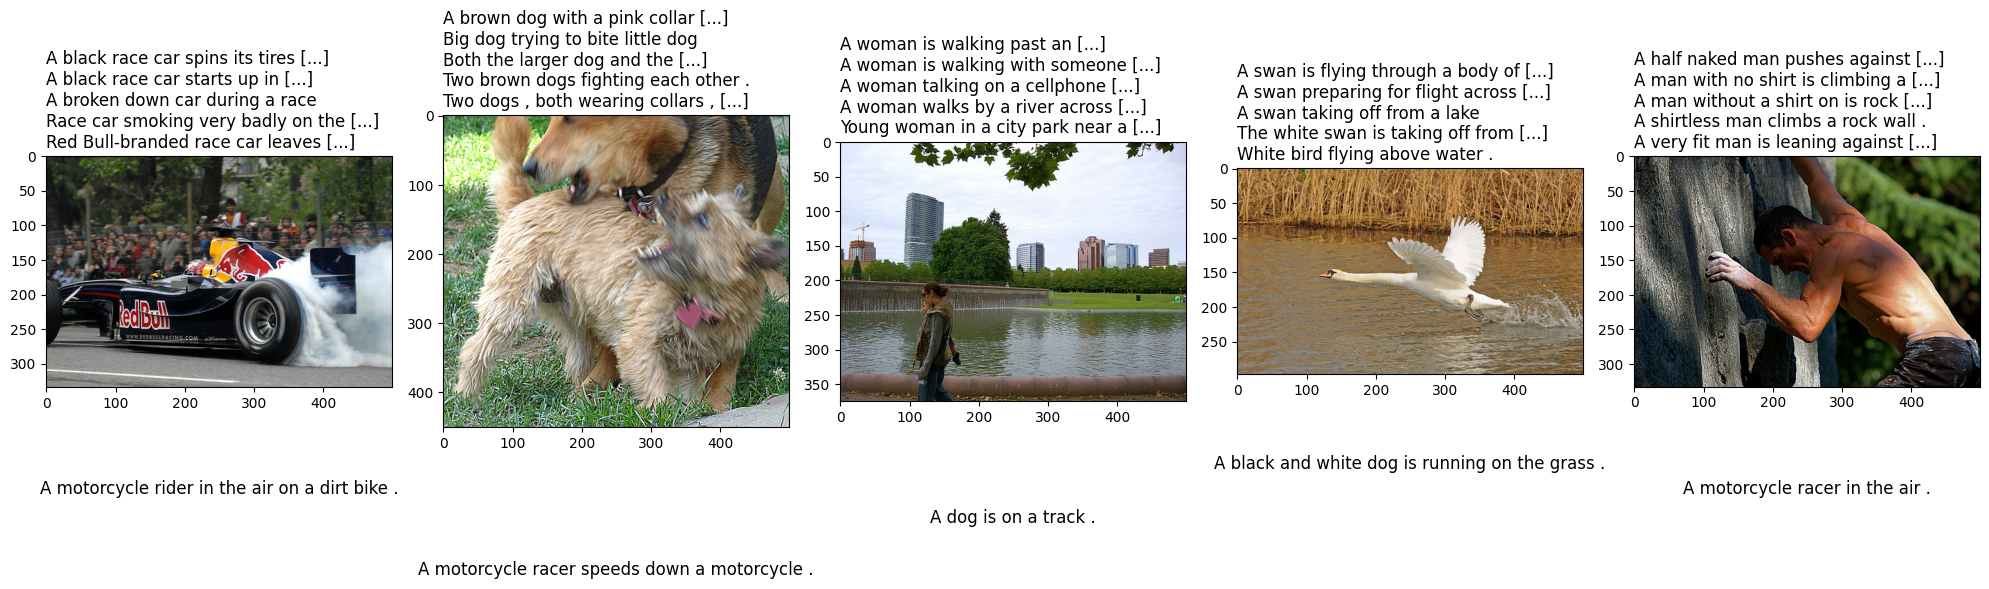

<IPython.core.display.Javascript object>

In [110]:
showcase_predictions(load_model(38, f"model#{20}"))

### 4.3 BLEU на всём val датасете

In [111]:
def get_bleu(model, split="val", sample=None):
    candidates = []
    references = []
    df = read_caption_dataframe(split)
    if sample:
        df = df.sample(sample)

    for img_id, captions in tqdm(df.iterrows(), total=len(df), desc="Calculating Bleu"):
        references.append(captions.values)
        img = imread(split, img_id)
        candidates.append([strip_special_tokens(generate(model, img))])

    return torchtext.data.metrics.bleu_score(candidates, references)

<IPython.core.display.Javascript object>

In [112]:
get_bleu(load_model(38, f"model#{20}"), sample=10)

Calculating Bleu:   0%|          | 0/10 [00:00<?, ?it/s]

0.0

<IPython.core.display.Javascript object>

## 5. Эксперименты (***3+ баллов***)

В этой части у вас не будет никакого написанного мною кода, а всё что вы здесь будете делать - на ваше усмотрение и по вашей задумке

Цель эксперментов:
**Пройти порог BLEU score на валидации (только делайте это честно, если где-то валидация будет протекать в обучение - 0 баллов за всё задание не думая)**

В блоке 4.3 при подсчёте BLEU на Val датасете вам нужно преодолеть следующие пороги:

**0.1** --> **1 балл**

**0.2** --> **2 балла**

**0.25** --> **3 балла**

В зависимости от решений других студентов пороги могут измениться, а за самые лучшие решения мы можем добавить дополнительные баллы. Эти дополнительные баллы не могут перейти на другие домашки, но могут помочь компенсировать потерянные в ходе именно этой лабораторной баллы в других частях.

**Так же важно:**
1. Процесс обучения данной модели должен находиться в данном ноутбуке в разделах 1-5, чтобы мы видели что чекпоинт правда ваш и написан/обучен вами.
2. Все эксперименты должны быть задокументированы: что вы пробовали, почему, какие результаты получили. Старайтесь максимально качественно описывать все свои эксперименты, потому что за отсутствие или за низкого качества описания экспериментов могут сниматься баллы. 

___Рисуйте графики, таблицы, не забывайте про то, что несколько графиков можно уместить в одном поле вывода, подписывайте оси, пишите заголовки.___

___Простой тест для самих себя - откройте свой ноутбук и дальше читайте только markdown-поля и выводы ячеек, но не сами ячейки с кодом.___

___Если, сделав это, вы не смогли понять что делалось в ноутбуке и какие результаты были получены - что-то явно не так и такого рода работа точно является кандидатом под снижение баллов за оформление и документацию экспериментов.___

___Так же старайтесь сделать оформление работы чистым при сдаче - мы можем снизить баллы, если общее качество оформления будет низким, т.к. проверять работы мы будем вручную.___


### **Удачи!**